In [24]:
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn
import statsmodels.tsa.stattools as ts
import numpy as np

from sklearn.model_selection import TimeSeriesSplit
from sklearn import linear_model
from sklearn.metrics import mean_squared_error 

In [58]:
# get history market data
hist = yf.Ticker('ARKK').history(start='2000-01-01', end='2018-12-31',interval='1d')

<AxesSubplot:xlabel='Date'>

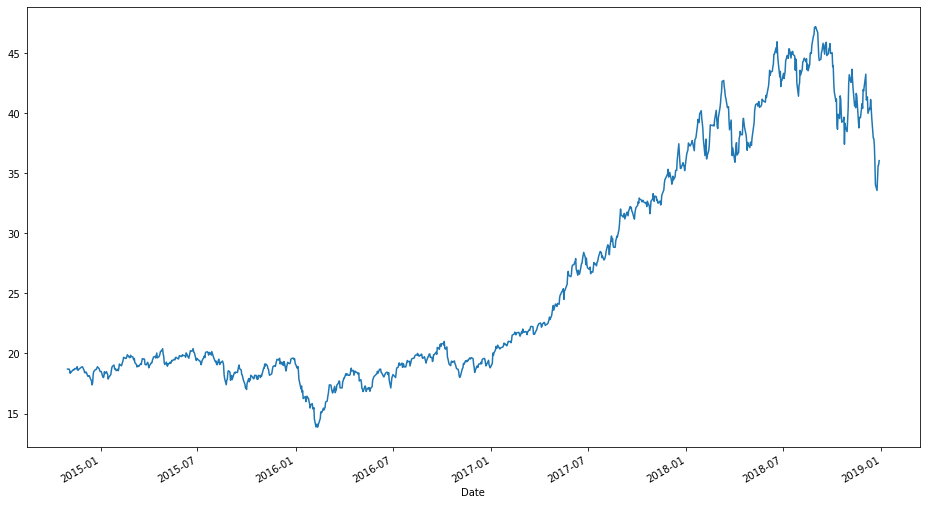

In [59]:
hist['Close'].plot(figsize=(16,9))

In [60]:
hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-10-31,18.734684,18.734684,18.697985,18.697985,2700,0.000,0
2014-11-03,18.798907,18.798907,18.670462,18.697985,2300,0.000,0
2014-11-04,18.532843,18.597066,18.532843,18.587891,7900,0.000,0
2014-11-05,18.817261,18.817261,18.349352,18.349352,14900,0.000,0
2014-11-06,18.431922,18.477795,18.413572,18.477795,2000,0.000,0
...,...,...,...,...,...,...,...
2018-12-21,36.122593,36.122593,33.889869,34.060886,737600,0.000,0
2018-12-24,33.661848,34.279411,33.158299,33.576340,425800,0.000,0
2018-12-26,33.842368,35.714055,33.536438,35.647549,959700,0.000,0


In [61]:
hist['Date'] = hist.index

# set id as index
id_list = list(range(hist.shape[0]))
hist.index = id_list

In [62]:
from fastai.tabular.all import *

# create date features
add_datepart(hist, 'Date')
hist.drop('Elapsed', axis=1, inplace=True)

In [63]:
hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
0,18.734684,18.734684,18.697985,18.697985,2700,0.000,0,2014,10,44,31,4,304,True,False,False,False,False,False
1,18.798907,18.798907,18.670462,18.697985,2300,0.000,0,2014,11,45,3,0,307,False,False,False,False,False,False
2,18.532843,18.597066,18.532843,18.587891,7900,0.000,0,2014,11,45,4,1,308,False,False,False,False,False,False
3,18.817261,18.817261,18.349352,18.349352,14900,0.000,0,2014,11,45,5,2,309,False,False,False,False,False,False
4,18.431922,18.477795,18.413572,18.477795,2000,0.000,0,2014,11,45,6,3,310,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1042,36.122593,36.122593,33.889869,34.060886,737600,0.000,0,2018,12,51,21,4,355,False,False,False,False,False,False
1043,33.661848,34.279411,33.158299,33.576340,425800,0.000,0,2018,12,52,24,0,358,False,False,False,False,False,False
1044,33.842368,35.714055,33.536438,35.647549,959700,0.000,0,2018,12,52,26,2,360,False,False,False,False,False,False
1045,35.390628,35.694622,34.076595,35.694622,525200,1.168,0,2018,12,52,27,3,361,False,False,False,False,False,False


In [64]:
# create date features
arkk = hist[['Open','High','Low','Volume','Dividends','Stock Splits','Month','Week','Day','Dayofweek']]

In [65]:
arkk

,Open,High,Low,Volume,Dividends,Stock Splits,Month,Week,Day,Dayofweek
0,18.734684,18.734684,18.697985,2700,0.000,0,10,44,31,4
1,18.798907,18.798907,18.670462,2300,0.000,0,11,45,3,0
2,18.532843,18.597066,18.532843,7900,0.000,0,11,45,4,1
3,18.817261,18.817261,18.349352,14900,0.000,0,11,45,5,2
4,18.431922,18.477795,18.413572,2000,0.000,0,11,45,6,3
...,...,...,...,...,...,...,...,...,...,...
1042,36.122593,36.122593,33.889869,737600,0.000,0,12,51,21,4
1043,33.661848,34.279411,33.158299,425800,0.000,0,12,52,24,0
1044,33.842368,35.714055,33.536438,959700,0.000,0,12,52,26,2
1045,35.390628,35.694622,34.076595,525200,1.168,0,12,52,27,3


In [68]:
y = hist['Close']
X_train = arkk[:int(arkk.shape[0]*0.7)].values
X_test = arkk[int(arkk.shape[0]*0.7):].values
y_train = y[:int(arkk.shape[0]*0.7)].values
y_test = y[int(arkk.shape[0]*0.7):].values

In [72]:
# check mean-reverting condition
arr = y.values
ro = ts.adfuller(arr, regression='ct', maxlag=1, autolag='AIC') 
print ('test statistic =',ro[0])  
print ('critical value =',ro[4])

test statistic = -1.7967911056012034
critical value = {'1%': -3.9674510711617947, '5%': -3.4146956215050186, '10%': -3.1295254998517468}


In [81]:
tscv = TimeSeriesSplit(n_splits=30)
i = 1
mse_score = []
for tr_indx, val_indx in tscv.split(X_train):
    X_tr, X_val = X_train[tr_indx], X_train[val_indx]
    y_tr, y_val = y_train[tr_indx], y_train[val_indx]
    
    model = linear_model.LinearRegression(fit_intercept=True, n_jobs=1, normalize=True)
    model.fit(X_tr, y_tr)
    y_hat = model.predict(X_val)
    score = mean_squared_error(y_val, y_hat)
    mse_score.append(score)

In [74]:
print("The average of mean squared score", np.mean(mse_score))

The average of mean squared score 0.00514918465762337


In [75]:
lr = linear_model.LinearRegression(fit_intercept=True, n_jobs=1, normalize=True)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
mean_squared_error(y_test, y_pred)

0.06290544815809536

### Use t-1 price as the feature

In [83]:
X = hist['Close'][:-1]
Y = hist['Close'][1:]

In [86]:
X_train = X[:int(X.shape[0]*0.7)].values.reshape(-1, 1)
X_test = X[int(X.shape[0]*0.7):].values.reshape(-1, 1)
y_train = Y[:int(arkk.shape[0]*0.7)].values.reshape(-1, 1)
y_test = Y[int(arkk.shape[0]*0.7):].values.reshape(-1, 1)

In [87]:
tscv = TimeSeriesSplit(n_splits=30)
i = 1
mse_score = []
for tr_indx, val_indx in tscv.split(X_train):
    X_tr, X_val = X_train[tr_indx], X_train[val_indx]
    y_tr, y_val = y_train[tr_indx], y_train[val_indx]
    
    model = linear_model.LinearRegression(fit_intercept=True, n_jobs=1, normalize=True)
    model.fit(X_tr, y_tr)
    y_hat = model.predict(X_val)
    score = mean_squared_error(y_val, y_hat)
    mse_score.append(score)
print("The average of mean squared score", np.mean(mse_score))

The average of mean squared score 0.07378351323950497


In [88]:
lr = linear_model.LinearRegression(fit_intercept=True, n_jobs=1, normalize=True)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
mean_squared_error(y_test, y_pred)

0.5051460922659995